In [1]:
%pylab inline

from PyTools import err, binner
from itertools import product
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
rc("lines", linewidth=1.0)
rc("patch", linewidth=1.0)
rc("font", family="sans-serif", serif="Helvetica", size=20)
rc("savefig", dpi=92)
rc("legend", fontsize="x-small")
rc("xtick", labelsize="x-small")
rc("ytick", labelsize="x-small")

ln = "M_spec log_t_M_spec log_t_L_spec log_Z_M_spec log_Z_L_spec Av_spec".split()
mn = "M_jpas log_t_M_jpas log_t_L_jpas log_Z_M_jpas log_Z_L_jpas Av_jpas".split()
rl = [True]+5*[False]
res_lbs = [r"$\Delta_r M_\star$", r"$\Delta\left<\log{t_\star}\right>_M$", r"$\Delta\left<\log{t_\star}\right>_L$",
           r"$\Delta\left<\log{Z_\star/Z\odot}\right>_M$", r"$\Delta\left<\log{Z_\star/Z\odot}\right>_L$",
           r"$\Delta A_V$"]

idir = "../inputs/real_deal6/Blues/"
odir = "../outputs/real_deal6/sanity_check/"

In [3]:
table = genfromtxt(odir+"sanity_uage_short.txt", dtype=None, names=True)
table = delete(table, where(np.isinf(table["u_mag"]))[0], axis=0)

lcolor = table["u_mag"]-table["r_mag"]

print "# galaxies: ", table.size

# galaxies:  99


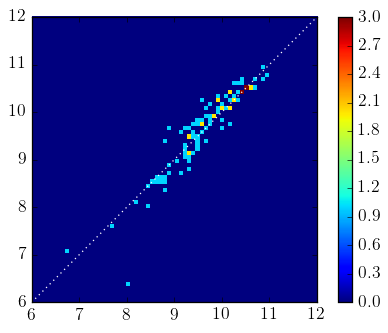

In [19]:
hist2d(log10(table["M_spec"]), log10(table["M_mod"]), 70, [[6., 12], [6., 12]])
colorbar()
#scatter(table["log_t_M_spec"], table["log_t_M_jpas"], lw=0, s=1, c="k", alpha=0.8)
#plot(table["log_t_M_spec"][mask], table["log_t_M_jpas"][mask], ".")
rm = ylim(xlim(6., 12))
plot(rm, rm, ":", lw=1, color="w")
gca().set_aspect("equal")

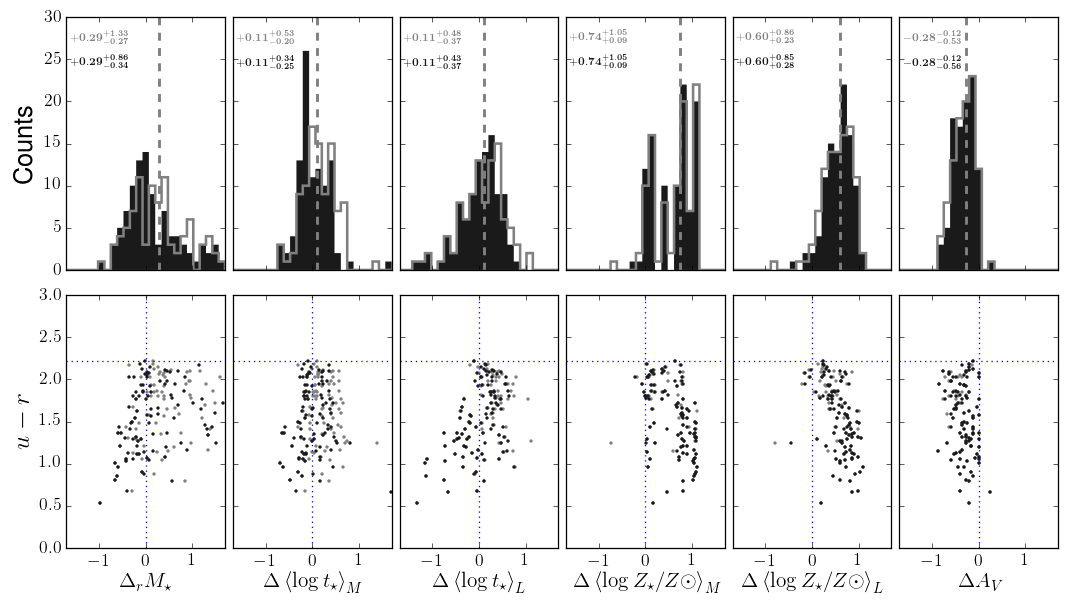

In [5]:
fig, axs = subplots(2, 6, figsize=(12, 7), sharex=True, sharey="row")

lm = xlim(-1.7, +1.7)
axs[0, 0].set_xticks([-1, 0, 1])

for i, j in product(xrange(axs.shape[0]), xrange(axs.shape[1])):
    res = err(table[ln[j]], table[mn[j]], rl[j])
    rsc = err(table[ln[j]], table[mn[j].replace("jpas", "mod")], rl[j])
    med = median(res)
    msc = median(res)
    p16, p84 = percentile(res, [16.0, 84.0])
    s16, s84 = percentile(rsc, [16.0, 84.0])
    
    if j == 0:
        if i == 0: axs[i, j].set_ylabel("Counts")
        if i == 1: axs[i, j].set_ylabel(r"$u-r$")
    
    if i == 0:
        axs[i, j].hist(rsc, 25, range=lm, histtype="stepfilled", fc="0.1", lw=0)
        axs[i, j].hist(res, 25, range=lm, histtype="step", ec="0.5", lw=2)
        
        axs[i, j].axvline(med, ls="--", color="0.5", lw=2)
        axs[i, j].axvline(msc, ls="--", color="0.5", lw=2)
        
        st_text = r"$\mathbf{%+.2f_{%+.2f}^{%+.2f}}$"%(med, p16, p84)
        ss_text = r"$\mathbf{%+.2f_{%+.2f}^{%+.2f}}$"%(msc, s16, s84)
        axs[i, j].text(0.02, 0.90, st_text, fontsize=9, color="0.5", ha="left", transform=axs[i, j].transAxes)
        axs[i, j].text(0.02, 0.80, ss_text, fontsize=9, color="0.1", ha="left", transform=axs[i, j].transAxes)
    else:
        x, y = binner(lcolor, res, "median", 10, rang=(0.5, 2))
        xs, ys = binner(lcolor, rsc, "median", 10, rang=(0.5, 2))

        axs[i, j].scatter(res, lcolor, s=7, lw=0, c="0.5")
        axs[i, j].scatter(rsc, lcolor, s=7, lw=0, c="0.1")
        #axs[i, j].plot(y, x, "-o", color="0.5", mew=0, ms=3)
        #axs[i, j].plot(ys, xs, "-o", color="0.1", mew=0, ms=3)

        axs[i, j].axvline(ls=":")
        axs[i, j].axhline(2.22, ls=":")
        
        axs[i, j].set_xlabel(res_lbs[j], size="small")
        axs[i, j].set_ylim(0.0, 3.0)

tight_layout()
subplots_adjust(wspace=0.05, hspace=0.1)

savefig("sanity_JPAS-SPEC.png", bbox_inches="tight")

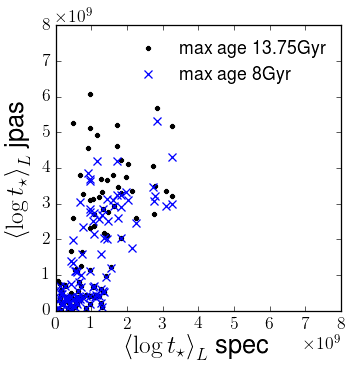

In [26]:
plot(10**table["log_t_L_spec"], 10**table["log_t_L_jpas"], ".k", label="max age 13.75Gyr")
plot(10**table["log_t_L_spec"], 10**table["log_t_L_mod"], "xb", label="max age 8Gyr")
legend(loc=0)
gca().set_aspect("equal")
ylim(xlim(0.0, 8e9))
xlabel(res_lbs[2].replace("\Delta", "")+" spec")
ylabel(res_lbs[2].replace("\Delta", "")+" jpas")

savefig("sanity_age_cons.png", bbox_inches="tight")

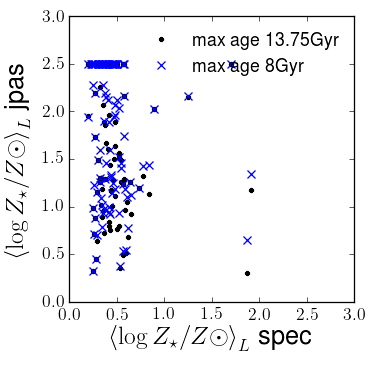

In [27]:
plot(10**table["log_Z_L_spec"], 10**table["log_Z_L_jpas"], ".k", label="max age 13.75Gyr")
plot(10**table["log_Z_L_spec"], 10**table["log_Z_L_mod"], "xb", label="max age 8Gyr")
legend(loc=0)
gca().set_aspect("equal")
ylim(xlim(0.0, 3))
xlabel(res_lbs[4].replace("\Delta", "")+" spec")
ylabel(res_lbs[4].replace("\Delta", "")+" jpas")

savefig("sanity_met_cons.png", bbox_inches="tight")

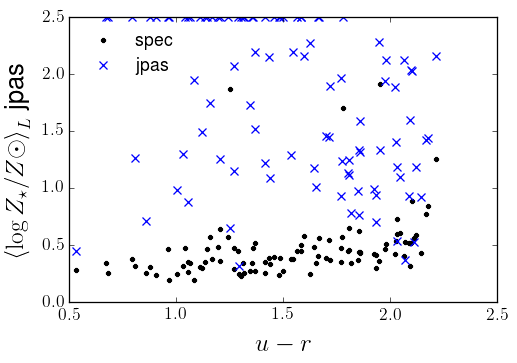

In [33]:
plot(lcolor, 10**table["log_Z_L_spec"], ".k", label="spec")
plot(lcolor, 10**table["log_Z_L_mod"], "xb", label="jpas")
legend(loc=0)

xlabel("$u-r$")
ylabel(res_lbs[4].replace("\Delta", "")+" jpas")

#savefig("sanity_met_cons.png", bbox_inches="tight")